In [1]:
from firedrake import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
fields = ["c"]


def get_function_spaces(mesh):
    return {"c": FunctionSpace(mesh, "CG", 1)}

def source(mesh):
    x, y = SpatialCoordinate(mesh)
    x0, y0, r = 2, 5, 0.05606388
    return 100.0 * exp(-((x - x0) ** 2 + (y - y0) ** 2) / r ** 2)

def get_form(mesh_seq):
    def form(index, sols):
        c, c_ = sols["c"]
        function_space = mesh_seq.function_spaces["c"][index]
        D = Constant(0.1)
        u = Constant(as_vector([1, 0]))
        h = CellSize(mesh_seq[index])
        S = source(mesh_seq[index])

        # Stabilisation parameter
        unorm = sqrt(dot(u, u))
        tau = 0.5 * h / unorm
        tau = min_value(tau, unorm * h / (6 * D))

        # Setup variational problem
        psi = TestFunction(function_space)
        psi = psi + tau * dot(u, grad(psi))
        F = (
            dot(u, grad(c)) * psi * dx
            + inner(D * grad(c), grad(psi)) * dx
            - S * psi * dx
        )
        return F

    return form

def get_bcs(mesh_seq):
    def bcs(index):
        function_space = mesh_seq.function_spaces["c"][index]
        return DirichletBC(function_space, 0, 1)

    return bcs

def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["c"][index]

        # Ensure dependence on the initial condition
        c_ = Function(function_space, name="c_old")
        c_.assign(ic["c"])
        c = Function(function_space, name="c")
        c.assign(c_)

        # Setup variational problem
        F = mesh_seq.form(index, {"c": (c, c_)})
        bc = mesh_seq.bcs(index)

        solve(F == 0, c, bcs=bc, ad_block_tag="c")
        return {"c": c}

    return solver

def get_qoi(mesh_seq, sol, index):
    def qoi():
        c = sol["c"]
        x, y = SpatialCoordinate(mesh_seq[index])
        xr, yr, rr = 20, 7.5, 0.5
        kernel = conditional((x - xr) ** 2 + (y - yr) ** 2 < rr ** 2, 1, 0)
        return kernel * c * dx

    return qoi

In [4]:
mesh_joe = RectangleMesh(200, 40, 50, 10)
time_partition = TimeInstant(fields)

msq = GoalOrientedMeshSeq(
    time_partition,
    mesh_joe,
    get_function_spaces=get_function_spaces,
    get_form=get_form,
    get_bcs=get_bcs,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="steady",
)

WARNING GoalOrientedMeshSeq: Adjoint action for field c on 0th subinterval is zero.
WARNING AdjointMeshSeq: Adjoint action for field c on 0th subinterval is zero.


Text(0.5, 1.0, 'Error indicator')

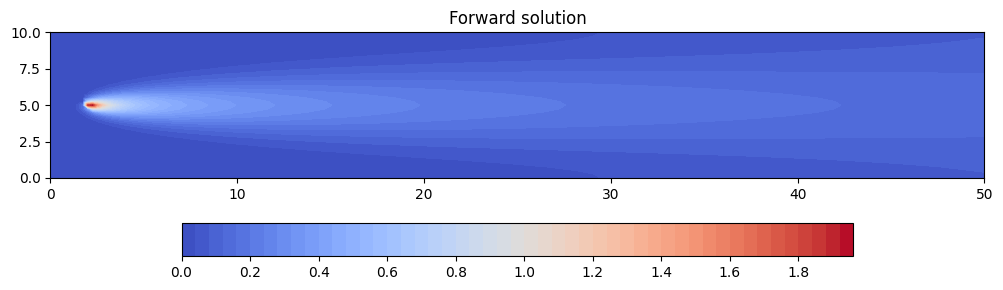

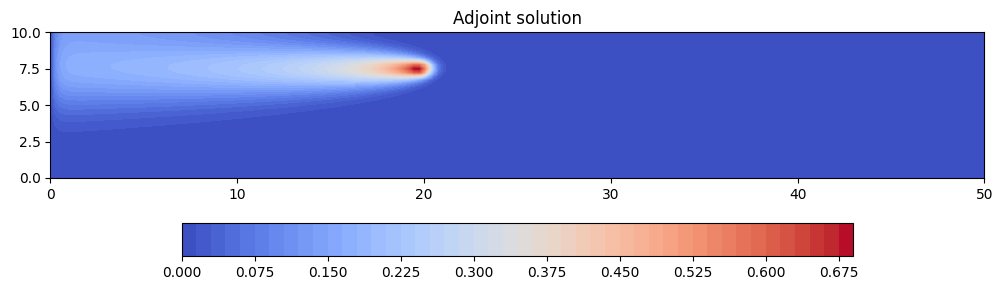

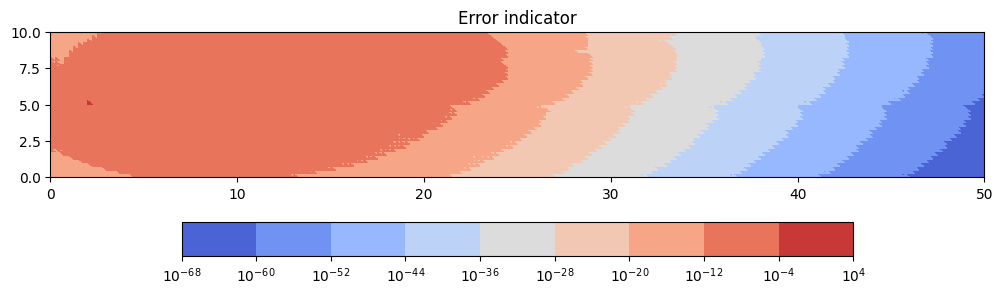

In [5]:
solutions, indicators = msq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "h"}
)

sol_c = solutions.c.forward[-1][-1]

import matplotlib.colors as mcolors
from matplotlib import ticker
plot_kwargs = {"levels": 50, "figsize": (10, 3), "cmap": "coolwarm"}
fig, axes, tcs = plot_snapshots(solutions, time_partition, "c", "forward", **plot_kwargs)
fig.colorbar(tcs[0][0], orientation="horizontal", pad=0.2)
axes.set_title("Forward solution")
fig, axes, tcs = plot_snapshots(solutions, time_partition, "c", "adjoint", **plot_kwargs)
fig.colorbar(tcs[0][0], orientation="horizontal", pad=0.2)
axes.set_title("Adjoint solution")
plot_kwargs["norm"] = mcolors.LogNorm()
plot_kwargs["locator"] = ticker.LogLocator()
fig, axes, tcs = plot_indicator_snapshots(indicators, time_partition, **plot_kwargs)
cbar = fig.colorbar(tcs[0][0], orientation="horizontal", pad=0.2)
axes.set_title("Error indicator")

In [55]:
import numpy as np
from numpy.linalg import eigh


def metric_from_hessian(hessian, tol):  # B is the 2d hessian matrix 2x2
    l_min = 1.
    l_max = 50e3

    B = np.array(hessian)

    # Compute mean diagonal and set values appropriately
    B[0, 1] = 0.5 * (B[0, 1] + B[1, 0])
    B[1, 0] = B[0, 1]

    # Solve eigenvalue problem
    eigen_values, eigen_vectors = eigh(B)

    # Take modulus of eigenvalues
    # eigen_values = np.clip(np.abs(eigen_values), l_min, l_max)
    mod_eigen_values = np.minimum(np.maximum(2/9 / tol * np.abs(eigen_values), 1/l_max**2), 1/l_min**2)

    # Build metric from eigendecomposition
    Q = eigen_vectors
    D = np.diag(mod_eigen_values)
    # A += Q @ D @ Q.T

    M = Q @ D @ Q.T
    return M

# M = metric_from_hessian(hess.dat.data[1000, :])
# same as hmet.dat.data[1000, :]

In [52]:
hess = recover_hessian(sol_c)
hmet = hessian_metric(hess)
hess_data = hess.dat.data
hess_met = np.zeros(hess_data.shape)
# hess_data.shape

for i in range(hess_data.shape[0]):
    hess_met[i] = metric_from_hessian(hess_data[i], 0.1)
    # print(hess_data[i])
    # print(hess_met[i])

hmet.dat.data[:] = hess_met

In [53]:
def adapt(mesh, metric):
    import firedrake.cython.dmcommon as dmcommon
    """
    Adapt the mesh with respect to the provided metric.
    :return: a new :class:`MeshGeometry`.
    """
    # metric = enforce_spd(mesh, metric, restrict_sizes=True, restrict_anisotropy=True)
    bsize = metric.dat.cdim
    size = [metric.dat.dataset.total_size * bsize] * 2
    v = PETSc.Vec().createWithArray(metric.dat.data_with_halos, size=size, bsize=bsize, comm=PETSc.COMM_SELF)
    newplex = mesh.topology_dm.adaptMetric(v, "Face Sets", "Cell Sets")
    v.destroy()
    return Mesh(newplex, distribution_parameters={"partition": False})

In [54]:
adapted_mesh = adapt(mesh_joe, hmet)
print(adapted_mesh.num_vertices())

5
